# Social Network Analysis

## Quick Summary

## Background

In [1]:
# accessing utils module
import sys
sys.path.append('../utils')

# needed for loading data:
import pandas as pd

# some problem-specific helper functions:
from utils import get_path, get_followers, plot_network_graph

# to visualize our network
import networkx as nx
# import matplotlib.pyplot as plt
# plt.style.use('seaborn')

# for our community analysis
from community import community_louvain

## The follower event database

Our dataset consists of over 609,080 follower-followee events:

- **follower** - The id of the person that initiated the follow
- **followee** - The id of the person being followed

Run the code below to load our data into our notebook!

In [2]:
print("Location of data files:", get_path('processed'))
print("Location of anonymized followers data:", get_path('processed/followers_deduped.csv'))
print("Loading...")
df = pd.read_csv(get_path('processed/followers_deduped.csv'), index_col=0)
print("...Done loading")
print("Displaying the first 5 rows...")
df.head(5)

Location of data files: /Users/matthewquinn/dev/eFuse-sample/data/processed
Location of anonymized followers data: /Users/matthewquinn/dev/eFuse-sample/data/processed/followers_deduped.csv
Loading...
...Done loading
Displaying the first 5 rows...


,follower,followee
0,782bc0ce5ffe00c95bbc52f72fc654a2,e83a54eefe2ff5daf80a66505f9472a4
1,e83a54eefe2ff5daf80a66505f9472a4,782bc0ce5ffe00c95bbc52f72fc654a2
2,782bc0ce5ffe00c95bbc52f72fc654a2,4627a06c99dde3d167166eaab32e947d
3,782bc0ce5ffe00c95bbc52f72fc654a2,49b76015d44936cb2c2184fc805e88a6
4,782bc0ce5ffe00c95bbc52f72fc654a2,1e66c9b143e9ee9155d0dcaa8d5997b0


## Setting up our network
Networks consist of nodes and edges. In our scenario, nodes will represent the user and edges are the links from one user to another. For our network, we'll need to identify a source and target group. We already have that in our data, but let's rename some columns to make this more apparent.

In [3]:
df.rename(columns={"follower":"target", "followee":"source"},inplace=True)
display(df.head())

,target,source
0,782bc0ce5ffe00c95bbc52f72fc654a2,e83a54eefe2ff5daf80a66505f9472a4
1,e83a54eefe2ff5daf80a66505f9472a4,782bc0ce5ffe00c95bbc52f72fc654a2
2,782bc0ce5ffe00c95bbc52f72fc654a2,4627a06c99dde3d167166eaab32e947d
3,782bc0ce5ffe00c95bbc52f72fc654a2,49b76015d44936cb2c2184fc805e88a6
4,782bc0ce5ffe00c95bbc52f72fc654a2,1e66c9b143e9ee9155d0dcaa8d5997b0


Great! To clarify the above:

- **target** - follows (follower) the source (followee)
- **source** - the users (followee) that recieved the follow

**Getting the source followers** In order to analyze our network, we'll need one to start with, ha! Hence, we'll need to be able to get the followers (target) of the gamer (source).

**For the purpose of illustration, for the remaining of this notebook, I'll be using a random example to demonstrate this analysis!**

In [4]:
example_user = "fffaf5721a5e42c72b2ed8b879edbe3a"

The above user will serve as our test account! Let's continue on by grabbing that user's followers and storing it in a dataframe!

In [5]:
example_network = pd.DataFrame(columns=["source","target"])
example_network["target"] = get_followers(df, example_user)
example_network["source"] = example_user
print("\nTaking a look at our users network!\n")
example_network


Taking a look at our users network!



,source,target
0,fffaf5721a5e42c72b2ed8b879edbe3a,d7cc098a5813710adc54799b71dc686a
1,fffaf5721a5e42c72b2ed8b879edbe3a,4e48ada1cb351bbecdc650842241faff
2,fffaf5721a5e42c72b2ed8b879edbe3a,6bc2e70ea4eb52748f58d38a1eac6130
3,fffaf5721a5e42c72b2ed8b879edbe3a,0f99bbbf354d2e11fce07fa26f1009d7
4,fffaf5721a5e42c72b2ed8b879edbe3a,18270c740e3887fd59efd539bf9df0f6
5,fffaf5721a5e42c72b2ed8b879edbe3a,098574931143f518897c57f89e015070
6,fffaf5721a5e42c72b2ed8b879edbe3a,c5c001468473f0ee648ac4d7b7fe3b82
7,fffaf5721a5e42c72b2ed8b879edbe3a,5e1ab920b988fb71f5ae532db2fc449e


This specific user has 8 follows, but let's go ahead and map this network!

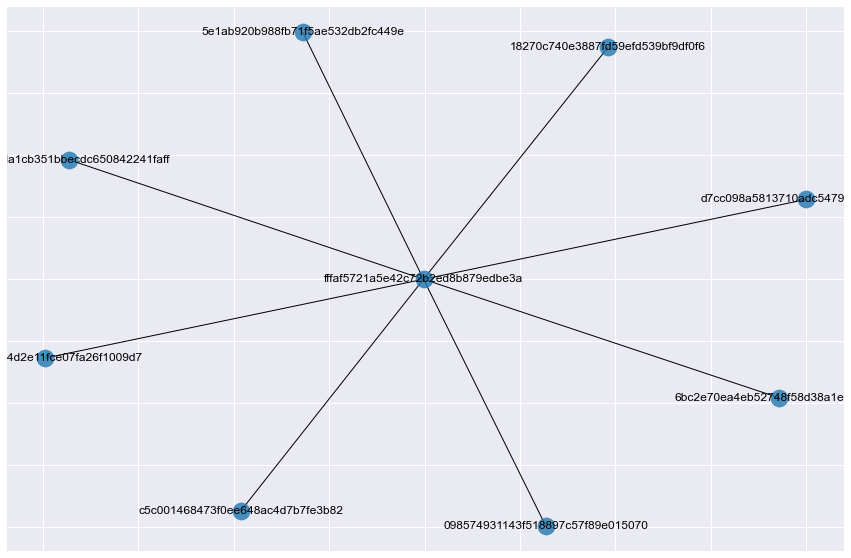

In [6]:
graph = nx.from_pandas_edgelist(example_network, "source", "target")
plot_network_graph(graph)

Okay, not bad, not bad! The chart is somewhat ugly, but here we see the users network. However, to really get a good grasp of the various communities within this network, we'll need to grab the followers of our followers!

## Our Network Analysis

In [7]:
user_list = list(example_network.target)
for user in user_list: 
    follower_list = get_followers(df, user)
    temp = pd.DataFrame(columns=['source', 'target'])
    temp['target'] = follower_list
    temp['source'] = user
    example_network = example_network.append(temp)

graph = nx.from_pandas_edgelist(example_network, 'source', 'target')
print("Number of nodes, or people, in our example network!", graph.number_of_nodes(), sep="\n ===> ")

Number of nodes, or people, in our example network!
 ===> 2627


Based on the folks that follow the accounts that follow us, our network is 2,627 large! Now that we have this, we can take a look at the most influential users in our network via a measurement of centrality. Also known as the number of followers each node has.

In [8]:
pd.DataFrame(sorted(
    graph.degree, key=lambda x: x[1], reverse=True
), columns=["names","degree"]).head()

,names,degree
0,5e1ab920b988fb71f5ae532db2fc449e,2214
1,c5c001468473f0ee648ac4d7b7fe3b82,316
2,098574931143f518897c57f89e015070,201
3,d7cc098a5813710adc54799b71dc686a,46
4,0f99bbbf354d2e11fce07fa26f1009d7,36


Based on the above, the most influencial follower in our example user's network is `5e1ab920b988fb71f5ae532db2fc449e` with a network of 2,214!

Let's go ahead and start our communnity analysis, based on groups and degree centrality. But before that, let's go ahead and trim out network.

**Removing network with less than nth degrees** To speed things up, and to prevent a huge network graph, let's go ahead and remove nodes from our graph that have less than 2 total nodes in their network. Let's make sure we continue to include our example user as the connector of this network!

In [9]:
remove = [node for node, degree in dict(graph.degree()).items() if degree < 4 and node != example_user]
graph.remove_nodes_from(remove)

There, now we've trimmed down the size of our network!

**Community Louvain** is a network analysis technique that allows us to split our network into groups belonging to the same or similar community of connections.

In [10]:
partition = community_louvain.best_partition(graph)
partition1 = pd.DataFrame([partition]).T
partition1 = partition1.reset_index().rename(columns={"index": "names", 0: "group"})
partition1.head()

,names,group
0,fffaf5721a5e42c72b2ed8b879edbe3a,0
1,d7cc098a5813710adc54799b71dc686a,1
2,4e48ada1cb351bbecdc650842241faff,0
3,6bc2e70ea4eb52748f58d38a1eac6130,0
4,0f99bbbf354d2e11fce07fa26f1009d7,2


Great! Now that we have our groups, let's re-running our code to generate the degree centrality since we've trimmed down our nodes.

In [11]:
degree_centrality = pd.DataFrame(sorted(
    graph.degree, key=lambda x: x[1], reverse=True
), columns=["names","degree"])
display(degree_centrality.head())

,names,degree
0,c5c001468473f0ee648ac4d7b7fe3b82,18
1,5e1ab920b988fb71f5ae532db2fc449e,18
2,098574931143f518897c57f89e015070,15
3,d7cc098a5813710adc54799b71dc686a,10
4,6bc2e70ea4eb52748f58d38a1eac6130,9


Now let's combined our groups with our degree centrality dataframe.

In [12]:
combined = pd.merge(degree_centrality, partition1, how='left', left_on="names", right_on="names")
combined.head()

,names,degree,group
0,c5c001468473f0ee648ac4d7b7fe3b82,18,0
1,5e1ab920b988fb71f5ae532db2fc449e,18,1
2,098574931143f518897c57f89e015070,15,2
3,d7cc098a5813710adc54799b71dc686a,10,1
4,6bc2e70ea4eb52748f58d38a1eac6130,9,0


Sweet! Now that this is done, we can go ahead and visualize what this looks like!

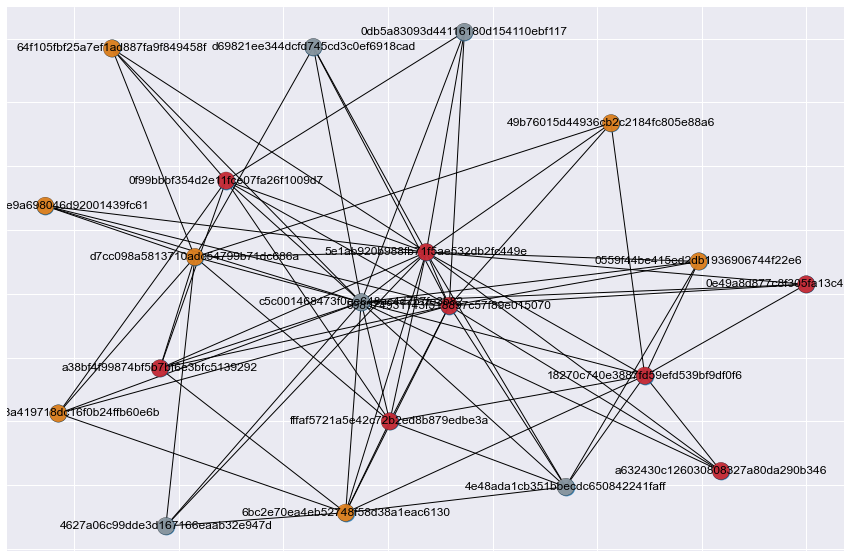

In [13]:
plot_network_graph(graph, plot_groups=combined)

**Wrapping up** Oop! Even reducing the nodes as much as we did, we still get a somewhat messy chart. However, we can see here that there are 3 distinct communities among this network. We can use this to make recommendations on who to follow based on who knows who within the folks that follow this user or who this user follows.